### Index

[1. Presentation of the challenge](#1) <br>
- [1.1 - The RavenPack Data Science Challenge](#1.1) <br>
- [1.2 - Overview of the approach](#1.2)<br><br>

[2. Collect & transform data](#2) <br>
- [2.1 - Connection à SQL Server](#2.1) <br>
- [2.2 - Mise au format des données](#2.2)<br>
- [](#2.3)<br>
- [](#2.4)<br>
- [](#2.5)<br>

[3. Descriptive analysis / Statistical inferences](#3) <br>
- [](#3.1)<br>
- [](#3.2)<br>
- [](#3.3)<br>
- [](#3.4)<br>

[4. Preprocess the data](#4) <br>
- [4.1 - Clustering](#4.1)<br>
- [4.2 - Création de la target (y)](#4.2)<br>
- [4.3 - Valeurs aberrantes](#4.3)<br>
- [4.4 - One-hot-encoding](#4.4)<br><br>

[5. Create features](#5) <br>
- [5.1 - Dataset du modèle 1](#5.1)<br>
- [](#5.2)<br>
- [](#5.3)<br>
- [](#5.4)<br>

[6. Select a ML algo](#6) <br>
- [6.1 - Dataset du modèle 1](#6.1)<br>
- [](#6.2)<br>
- [](#6.3)<br>
- [](#6.4)<br>

[7. Backtest on unseen data](#7) <br>
- [7.1 - Dataset du modèle 1](#7.1)<br>
- [](#7.2)<br>
- [](#7.3)<br>
- [](#7.4)<br>

___
# <a id =1> </a>  **1. Presentation of the challenge**
___

### 1.1 <a id =1.1> </a>The RavenPack Data Science Challenge

<br>

Dataset (in csv format) with the following structure (column wise):

<br>

| label : | 'description' |
| ----------- | ----------- |
| DATE | A given date |
|  RP_ENTITY_ID | An asset ID |
|  T0_RETURN | Return on the given date |
|  T1_RETURN |  Next day Return |
|  A set of 36 different Indicators |  (Features) |

<br>

<p style="border: 0px ridge white;
          color: color_police;
          background-color: colr;
          padding: 5rem;
          display: flex;
          flex-direction: column;
          font: small-caps bold 2rem sans-serif;
          text-align: justify;">
The aim of this project is to come up with a model/algorithm to produce predictions on T1_RETURN using the available information.
    <br><br>
You are expected to use said predictions to form a portfolio that will then be evaluated according to Information Ratio.
</p>

<br>

**As an output, you are asked to provide:**

- A short report on what you have done together with some results and conclusions, including a performance comparison among the models you propose, using Information Ratio as a metric.

- The source code used for producing your analysis and results.

<br><br>
The project will allow us to evaluate your skill set within programming, data preparation, modeling, and communication. 

<br><br>
links to the files :

https://drive.google.com/a/rav...

https://drive.google.com/a/rav...

<pre><code>
#################################
#######  SAMPLE CODE   ##########
#################################
library(data.table)
# Open CSV file and convert to data table*
# Full path to your csv file
fullPath = \<The path to the provided csv file goes here>
DataSet = data.table(read.csv(file = fullPath))
# We have a panel data.table with information about dates, Entity IDs, Returns (T1 and T0), and 36 different indicators).


### Example on how to check the performance of a given prediction.
# Lets say we are using the sign of an indicator(GROUP_E_ALL_SG90) as predictor
# We select only the data we are interested in
PredictionData = subset(DataSet, select = c('DATE', 'RP_ENTITY_ID','GROUP_E_ALL_SG90', 'T1_RETURN'))
# We drop NA's
PredictionData = PredictionData[complete.cases(PredictionData)]
# We get unique rows
PredictionData = unique(PredictionData)
# We sort by DATE, setting its key
setkey(PredictionData,'DATE')
# Compute Average Return per day using the sign of the indicator as predictor*
PredictionData[, AVGRET:= mean(sign(GROUP_E_ALL_SG90)*T1_RETURN,na.rm = TRUE), by = c('DATE')]
Results = subset(PredictionData,select = c('DATE','AVGRET'))
Results = unique(Results)
# We plot the Cummulative Log Returns
plot( as.Date(Results$DATE), cumsum(log(Results$AVGRET+1)), t = 'l', col = 'blue', ylab = 'Cummulative Return', xlab = 'DATE')


### Some Stats
# AnnualizedReturn
AnnualizedReturn = mean(log(Results$AVGRET+1))*252
# AnnualizedVolatility
AnnualizedVolatility = sqrt(var(log(Results$AVGRET+1)))*sqrt(252)
# Information Ratio 
InformationRatio = AnnualizedReturn/AnnualizedVolatility
title(paste('Return Profile - Information Ratio', round(InformationRatio,2)))

</code>
</pre>

### <a id =1.2> </a> 1.2 Overview of the approach

___
# <a id =2> </a> **2. Collect & transform data**
___

In [1]:
import pandas as pd
import numpy as np
import statistics
import plotly.graph_objects as go
from IPython.core.display import display, HTML
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tslearn.utils import to_time_series_dataset

In [2]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
# from yellowbrick.model_selection import ValidationCurve, LearningCurve

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = None

In [4]:
display(HTML("<style> *{margin:0; padding:0;} html, body, \
             .container{margin:2;!important padding:0;!important} \
             .container { width:100% !important;}</style>"))


In [5]:
df = pd.read_csv('../SampleDataSet.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
descr = df.describe()
df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
###col with 100% NA
cols_to_drop = descr.columns[descr.loc['count',:]==0]
###delete these cols
df = df.loc[:, ~df.columns.isin(cols_to_drop)]
q = 0.9995
df = df.loc[ (df['T0_RETURN']<df['T0_RETURN'].quantile(q)) 
            & (df['T0_RETURN']>df['T0_RETURN'].quantile(1-q)) 
            & (df['T1_RETURN']<df['T1_RETURN'].quantile(q)) 
            & (df['T1_RETURN']>df['T1_RETURN'].quantile(1-q)) ]

ret = 0.01
perf_range = (df['T1_RETURN']>=ret) | (df['T1_RETURN']<=-ret)
df_perf = df.loc[ perf_range ]

nb_date_ceil = 10000
nb_date_floor = 756 #3y track record
list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)&(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)

df_track_perf = df_perf.loc[df_perf['RP_ENTITY_ID'].isin(list_asset),:]
# df_track_perf.describe()

df_track_perf['T0_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T0_RETURN'].copy()) ##use log return
df_track_perf['T1_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df_track_perf = df_track_perf.loc[:, ~df_track_perf.columns.isin(cols_to_drop)]

df_track_perf

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log
2,00067A,2005-01-20,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.010,0.019
4,00067A,2005-01-26,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.001,0.012
7,00067A,2005-02-08,-0.090,-0.106,0.075,-0.055,-0.088,0.610,-0.055,-0.088,0.610,nan,nan,0.075,nan,nan,nan,nan,nan,nan,-0.090,-0.106,0.075,-0.055,-0.088,0.610,-0.055,-0.088,0.610,0.075,-0.000,-0.018
9,00067A,2005-02-16,0.405,0.466,0.363,0.269,0.190,0.328,0.262,0.000,0.328,nan,nan,0.363,nan,nan,nan,nan,nan,nan,0.360,0.350,0.363,0.218,0.000,0.328,0.262,0.000,0.328,0.363,0.009,0.015
15,00067A,2005-03-23,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.005,0.014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712416,FF6644,2016-10-11,-0.279,0.113,-0.475,-0.062,0.113,-0.590,-0.083,0.170,-0.590,0.113,0.113,-0.475,0.113,0.113,nan,0.170,0.170,nan,-0.680,nan,-0.475,-0.590,nan,-0.590,-0.590,nan,-0.590,-0.475,0.005,0.014
712417,FF6644,2016-10-12,0.668,0.950,0.612,nan,nan,nan,nan,nan,nan,0.950,0.950,0.612,nan,nan,nan,nan,nan,nan,0.610,nan,0.612,nan,nan,nan,nan,nan,nan,0.612,0.014,0.011
712443,FF6644,2016-12-09,0.775,0.940,0.610,0.775,0.940,0.610,0.775,0.940,0.610,0.940,0.940,0.610,0.940,0.940,nan,0.940,0.940,nan,0.610,nan,0.610,0.610,nan,0.610,0.610,nan,0.610,0.610,0.004,0.016
712470,FF6644,2017-01-27,0.101,0.027,0.170,0.044,-0.007,0.192,0.039,-0.007,0.194,0.167,nan,0.170,nan,nan,nan,nan,nan,nan,0.093,0.025,0.170,0.042,-0.010,0.192,0.037,-0.010,0.194,0.170,0.007,0.013


In [6]:
df.head()

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN,T1_RETURN
0,00067A,2005-01-05,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.030,-0.006
1,00067A,2005-01-06,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.006,-0.005
2,00067A,2005-01-20,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.010,0.019
3,00067A,2005-01-21,0.001,0.010,0.000,0.001,0.010,0.000,0.001,0.010,0.000,0.010,0.010,0.000,0.010,0.010,nan,0.010,0.010,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,0.019,0.002
4,00067A,2005-01-26,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.001,0.012


In [ ]:
df.info()

In [ ]:
# df.RP_ENTITY_ID.value_counts().describe()

In [ ]:
# ###number of rows when selecting assets with a track record > 3 years
# nb_assets = (df.RP_ENTITY_ID.value_counts()>=0).sum()
# nb_assets_3y = (df.RP_ENTITY_ID.value_counts()>756).sum()
# df.RP_ENTITY_ID.value_counts()[:-(nb_assets-nb_assets_3y)].sum()

In [ ]:
# df.iloc[:,:].isna().sum(axis=0)

In [ ]:
# df.iloc[:,:].isna().sum(axis=0)/len(df)

___
# <a id =3> </a> **3. Descriptive analysis / Statistical inferences**
___

##### Missing values

In [ ]:
# # plt.figure(figsize=(15,10))
# data = df.loc[:,:].isna().melt(value_name="missing")
# sorter = data.groupby('variable').sum().sort_values(by=['missing'], ascending=True).index.to_list()
# data.variable = data.variable.astype("category")
# data.variable.cat.set_categories(sorter, inplace=True)
# data = data.sort_values(["variable"])
# ax = sns.displot(
#     data=data,
#     y="variable",
#     hue="missing",
#     multiple="fill",
#     aspect=1.25
# )
# # plt.legend(data['missing'].unique(), loc='lower left', bbox_to_anchor=(0, 1), facecolor='w', edgecolor='w')
# ax.fig.set_size_inches(20,10)
# plt.title('Total', fontsize=18, color='w')
# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')
# plt.xlabel('count', fontsize=16, c='w')
# plt.ylabel('feature', fontsize=16, c='w')
# plt.legend(fontsize=26)

In [ ]:


# f, ax = plt.subplots(figsize=(35, 10))
# corr = df.iloc[:,2:].isna().corr()

# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# cmap=sns.diverging_palette(220, 10, as_cmap=True)

# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5});
# plt.title('Correl missing values', fontsize=18, color='w')
# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')

In [ ]:
## Missing value: no evident temporal structure (date, day, month, year)
### MNAR Missing not at random (also known as nonignorable nonresponse) is data that is neither MAR nor MCAR (i.e. the value of the variable that's missing is related to the reason it's missing)
### Generally speaking, there are 3 main approaches to handle missing data: 
#### (1) Imputation—where values are filled in the place of missing data, 
#### (2) omission—where samples with invalid data are discarded from further analysis,
#### (3) analysis—by directly applying methods unaffected by the missing values. 
    
    
    
###Imputations with RF are good for strong non-linear relationships between continuous variables and when there are interactions


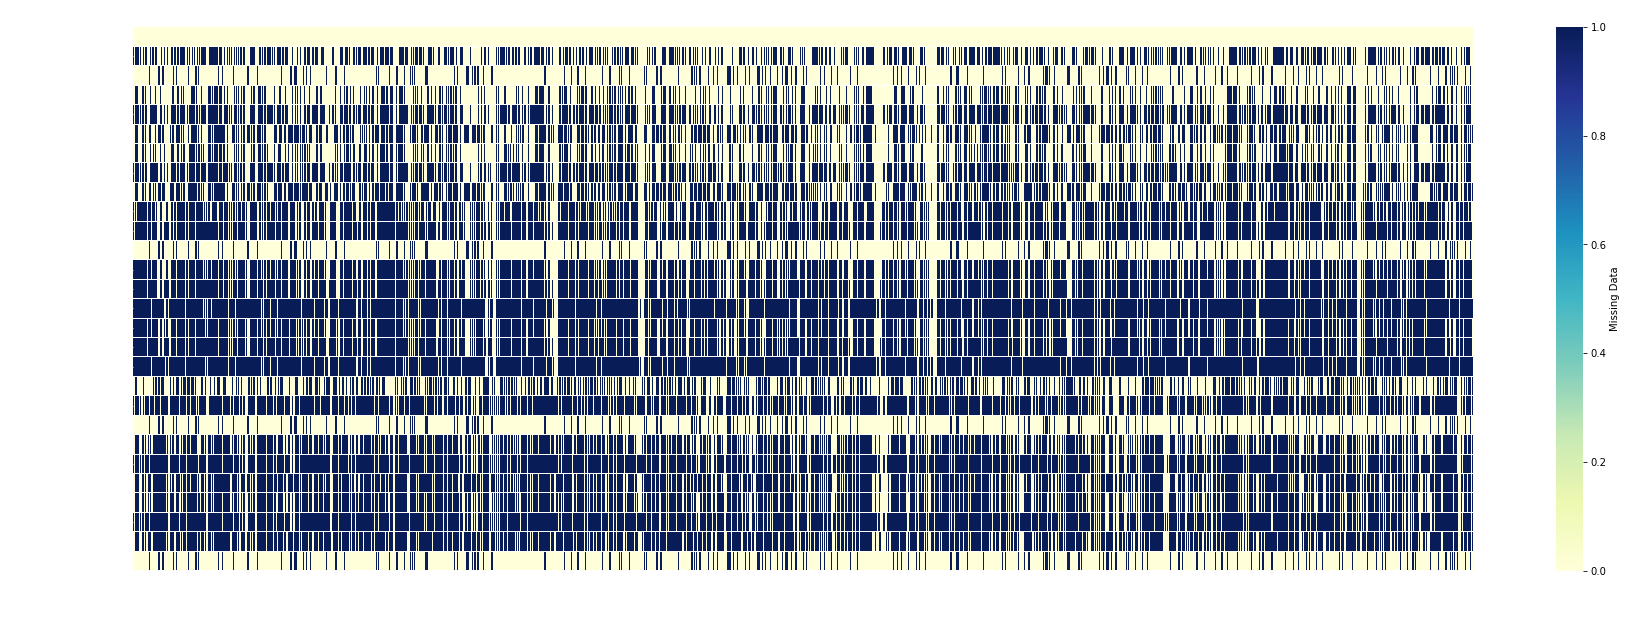

In [7]:
plt.figure(figsize=(30,10))
sns.heatmap(df.iloc[:,2:-2].isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
# ax.fig.set_size_inches(35,12)
plt.title('Total', fontsize=18, color='w')
plt.tick_params(axis='x', colors='w')
plt.tick_params(axis='y', colors='w')

In [ ]:
# plt.figure(figsize=(30,10))
# sorted_df = df.sort_values(by=['GLOBAL_HEAD', 'GLOBAL_BODY'], ascending=True)
# sns.heatmap(sorted_df.iloc[:,2:-2].isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# # ax.fig.set_size_inches(35,12)
# plt.title("sorted by=['GLOBAL_HEAD', 'GLOBAL_BODY']", fontsize=18, color='w')
# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')

In [ ]:
# plt.figure(figsize=(30,10))
# sorted_df = df.sort_values(by=['GLOBAL_HEAD'], ascending=True)
# sns.heatmap(sorted_df.iloc[:,2:-2].isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# # ax.fig.set_size_inches(35,12)
# plt.title("sorted by=['GLOBAL_HEAD', 'GLOBAL_BODY']", fontsize=18, color='w')
# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')

In [ ]:
# plt.figure(figsize=(30,10))
# sorted_df = df.sort_values(by=['GLOBAL_BODY'], ascending=True)
# sns.heatmap(sorted_df.iloc[:,2:-2].isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# # ax.fig.set_size_inches(35,12)
# plt.title("sorted by=['GLOBAL_HEAD', 'GLOBAL_BODY']", fontsize=18, color='w')
# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')

In [ ]:
# plt.figure(figsize=(30,10))
# sorted_df = df.sort_values(by=['GROUP_A_ALL'], ascending=True)
# sns.heatmap(sorted_df.iloc[:,2:-2].isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# # ax.fig.set_size_inches(35,12)
# plt.title("sorted by=['GLOBAL_HEAD', 'GLOBAL_BODY']", fontsize=18, color='w')
# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')

In [ ]:
# plt.figure(figsize=(30,10))
# sorted_df = df.sort_values(by=['GROUP_E_ALL'], ascending=True)
# sns.heatmap(sorted_df.iloc[:,2:-2].isna().transpose(),
#             cmap="YlGnBu",
#             cbar_kws={'label': 'Missing Data'})
# # ax.fig.set_size_inches(35,12)
# plt.title("sorted by=['GLOBAL_HEAD', 'GLOBAL_BODY']", fontsize=18, color='w')
# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')

##### Features

,0.250
GLOBAL_ALL,0.000
GLOBAL_HEAD,0.000
GLOBAL_BODY,0.000
GLOBAL_ALL_SG90,0.000
GLOBAL_HEAD_SG90,0.000
GLOBAL_BODY_SG90,0.000
GLOBAL_ALL_SG365,0.000
GLOBAL_HEAD_SG365,0.000
GLOBAL_BODY_SG365,0.000
GROUP_A_ALL,0.000


In [98]:

return_ = 0.08
df_up_inter = df.copy()#.describe()
df_up_inter = df_up_inter.loc[df_up_inter['T0_RETURN']>=return_,:]
df_up_inter = df_up_inter.iloc[:,2:-2]
df_up = pd.DataFrame(df_up_inter.mean(), columns=['mean'])
df_up = pd.concat([df_up, pd.DataFrame(df_up_inter.quantile(0.05))], axis=1)
df_up = pd.concat([df_up, pd.DataFrame(df_up_inter.quantile(0.25))], axis=1)
df_up = pd.concat([df_up, pd.DataFrame(df_up_inter.median(), columns=['median'])], axis=1)
df_up = pd.concat([df_up, pd.DataFrame(df_up_inter.quantile(0.75))], axis=1)
df_up = pd.concat([df_up, pd.DataFrame(df_up_inter.quantile(0.95))], axis=1)
df_up = pd.concat([df_up, pd.DataFrame(df_up_inter.std(), columns=['std'])], axis=1)
df_up = pd.concat([df_up, pd.DataFrame(df_up_inter.count(), columns=['count'])], axis=1)
# display(pd.DataFrame(df_up))

df_down_inter = df.copy()#.describe()
df_down_inter = df_down_inter.loc[df_down_inter['T0_RETURN']<=-return_,:]
df_down_inter = df_down_inter.iloc[:,2:-2]
df_down = pd.DataFrame(df_down_inter.mean(), columns=['mean'])
df_down = pd.concat([df_down, pd.DataFrame(df_down_inter.quantile(0.05))], axis=1)
df_down = pd.concat([df_down, pd.DataFrame(df_down_inter.quantile(0.25))], axis=1)
df_down = pd.concat([df_down, pd.DataFrame(df_down_inter.median(), columns=['median'])], axis=1)
df_down = pd.concat([df_down, pd.DataFrame(df_down_inter.quantile(0.75))], axis=1)
df_down = pd.concat([df_down, pd.DataFrame(df_down_inter.quantile(0.95))], axis=1)
df_down = pd.concat([df_down, pd.DataFrame(df_down_inter.std(), columns=['std'])], axis=1)
df_down = pd.concat([df_down, pd.DataFrame(df_down_inter.count(), columns=['count'])], axis=1)
# display(pd.DataFrame(df_down))


from IPython.core.display import display, HTML
#affiche les tableaux côte à côte
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

display_side_by_side([df_up, df_down], ['df_up', 'df_down'])

,mean,0.05,0.25,median,0.75,0.95,std,count
GLOBAL_ALL,0.260777,-0.517863,0.010908,0.314637,0.530558,0.864750,0.373683,6842
GLOBAL_HEAD,0.323922,-0.423471,0.051806,0.406196,0.585247,0.940000,0.383384,5587
GLOBAL_BODY,0.216672,-0.560000,0.000000,0.244338,0.472280,0.650000,0.357927,6274
GLOBAL_ALL_SG90,0.297858,-0.392350,0.064130,0.348333,0.545585,0.940000,0.356332,6147
GLOBAL_HEAD_SG90,0.337859,-0.401861,0.061200,0.414444,0.602857,0.940000,0.380554,5341
GLOBAL_BODY_SG90,0.230114,-0.429929,0.027083,0.258804,0.456339,0.640000,0.325323,5303
GLOBAL_ALL_SG365,0.299197,-0.428926,0.049048,0.360000,0.556538,0.940000,0.365508,6013
GLOBAL_HEAD_SG365,0.336830,-0.409006,0.055101,0.413810,0.606083,0.940000,0.382689,5258
GLOBAL_BODY_SG365,0.235454,-0.502356,0.000000,0.280000,0.505218,0.650000,0.346665,5116
GROUP_A_ALL,0.374325,-0.580000,0.000000,0.592632,0.940000,0.940000,0.566809,2897


In [ ]:
# y1 = pd.DataFrame(pd.DataFrame(dico_y['optim'])['y1'])
# slots = pd.DataFrame(dico_y_slot['optim'])[1:-1]
# data_pairplot = pd.merge(y1, slots, left_index=True, right_index=True)

In [ ]:
# df = df.groupby(['DATE','RP_ENTITY_ID'], as_index=False).first()
# df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()

# # df.sort_values(by=['RP_ENTITY_ID','DATE'])
# df = pd.read_csv('../SampleDataSet.csv')
# df['DATE'] = pd.to_datetime(df['DATE'])
# df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
# ###col with 100% NA
# cols_to_drop = descr.columns[descr.loc['count',:]==0]
# ###delete these cols
# df = df.loc[:, ~df.columns.isin(cols_to_drop)]


# f, ax = plt.subplots(figsize=(35, 10))
# corr = df.iloc[:,2:].corr()

# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# cmap=sns.diverging_palette(220, 10, as_cmap=True)

# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
# df = pd.read_csv('../SampleDataSet.csv')
# df['DATE'] = pd.to_datetime(df['DATE'])
# df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
# ###col with 100% NA
# cols_to_drop = descr.columns[descr.loc['count',:]==0]
# ###delete these cols
# df = df.loc[:, ~df.columns.isin(cols_to_drop)]


# f, ax = plt.subplots(figsize=(35, 10))
# retained_cols = ['GROUP_A_ALL','GROUP_A_HEAD','GROUP_A_BODY','GROUP_E_ALL','GROUP_E_HEAD','T0_RETURN', 'T1_RETURN']

# dfna = df.dropna()
# corr = dfna.iloc[:,2:].corr()

# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# cmap=sns.diverging_palette(220, 10, as_cmap=True)

# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [ ]:
# corr = data_pairplot.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2).set_properties(**{'font-size': '12pt'})

In [ ]:
# g = sns.PairGrid(df.iloc[0:500,2:-2])
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)

In [ ]:
# cols = df.columns[2:]

# fig = plt.figure(figsize=(25, 15))
# fig.subplots_adjust(hspace=0.3, wspace=0.2)

# for i,col in enumerate(cols):
#     ax = fig.add_subplot(8, 4, i+1)
#     sns.histplot(df[col], ax=ax)
# plt.show()
    
    

##### Target

In [ ]:
# cols = ['T0_RETURN','T1_RETURN']

# fig = plt.figure(figsize=(20, 10))
# fig.subplots_adjust(hspace=0.2, wspace=0.2)

# for i,col in enumerate(cols):
#     ax = fig.add_subplot(1, 2, i+1)
#     sns.histplot(df[col], ax=ax)
# plt.show()

In [ ]:
# q = 0.9995
# descr_qsplit = np.concatenate(([1-q], np.arange(0.05,0.95,0.05), [q]), axis=0)
# df[['T0_RETURN','T1_RETURN']].describe(descr_qsplit)

In [ ]:

# import seaborn as sns
# sns.set(rc = {'figure.figsize':(15,8)})
# ax = sns.violinplot(data=df[["T0_RETURN","T1_RETURN"]], orient="v", palette="Set2")


In [ ]:
# q = 0.9995
# df_violin = pd.DataFrame()
# df_violin['T0_RETURN'] = df['T0_RETURN'].loc[ (df['T0_RETURN']<df['T0_RETURN'].quantile(q)) & (df['T0_RETURN']>df['T0_RETURN'].quantile(1-q)) ]
# df_violin['T1_RETURN'] = df['T1_RETURN'].loc[ (df['T1_RETURN']<df['T1_RETURN'].quantile(q)) & (df['T1_RETURN']>df['T1_RETURN'].quantile(1-q)) ]

# ax = sns.violinplot(data=df_violin[["T0_RETURN","T1_RETURN"]], orient="v", palette="Set2")

In [ ]:
# q = 0.9995
# df = df.loc[ (df['T0_RETURN']<df['T0_RETURN'].quantile(q)) 
#             & (df['T0_RETURN']>df['T0_RETURN'].quantile(1-q)) 
#             & (df['T1_RETURN']<df['T1_RETURN'].quantile(q)) 
#             & (df['T1_RETURN']>df['T1_RETURN'].quantile(1-q)) ]

In [ ]:
# df_melted = pd.melt(df[['T0_RETURN', 'T1_RETURN']])
# # df_melted = df_melted.loc[(df_melted['value']<=-0.005)|(df_melted['value']>=0.005)]
# # df_melted_log = pd.DataFrame()
# # df_melted_log['variable'] = df_melted['variable'] 
# # df_melted_log['value'] = np.log(1+df_melted['value'])

# ax = sns.displot(df_melted, x="value", hue="variable", kind="kde", fill=True)
# ax.fig.set_size_inches(15,5)
# sns.move_legend(
#     ax, "left",
#     bbox_to_anchor=(0.465, 0.98), ncol=3, title=None, frameon=False,
# )
# plt.title('T0 and T1 density', fontsize=18, color='w')
# plt.xlabel('value', fontsize=16, color='w')
# plt.ylabel('density', fontsize=16, color='w')
# plt.tick_params(axis='x', colors='w')
# plt.tick_params(axis='y', colors='w')

In [ ]:
ret = 0.02
perf_range = (df['T1_RETURN']>=ret) | (df['T1_RETURN']<=-ret)
df_perf = df.loc[ perf_range ]
df_perf.describe()

In [ ]:
nb_date_ceil = 10000
nb_date_floor = 504 #3y track record
list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)&(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)

In [ ]:
df_track_perf['T0_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T0_RETURN'].copy()) ##use log return
df_track_perf['T1_RETURN_log'] = np.log(1+df_track_perf.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df_track_perf = df_track_perf.loc[:, ~df_track_perf.columns.isin(cols_to_drop)]

X_all = df_track_perf.iloc[:,2:-1]
y = df_track_perf.T1_RETURN_log

In [ ]:
### Bivariate Scatter Plots
sns.set_style('whitegrid')
g = sns.pairplot(X_all.iloc[:,:10].assign(T1_RETURN_log=y), y_vars=['T1_RETURN_log'], x_vars=X_all.columns[:10])
sns.despine();

In [ ]:
### Bivariate Scatter Plots
g = sns.pairplot(X_all.iloc[:,10:20].assign(T1_RETURN_log=y), y_vars=['T1_RETURN_log'], x_vars=X_all.columns[10:20])
sns.despine();

In [ ]:
### Bivariate Scatter Plots
g = sns.pairplot(X_all.iloc[:,20:].assign(T1_RETURN_log=y), y_vars=['T1_RETURN_log'], x_vars=X_all.columns[20:])
sns.despine();

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
correl = X_all.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

In [ ]:
beg = '2005-01-03'
freq = 'D'
# alpha=0.1

fig = go.Figure()
for asset in list_asset:
    df2 = df.query("RP_ENTITY_ID==@asset")#['DATE'].loc['2005-01-03':, :]
    df2 = df2[df2['DATE']>=beg]
    df2['PRICE'] = 100*(1 + df2['T0_RETURN']).cumprod()
    df2['PRICE'] = df2['PRICE'].shift(1)
#     df2['T0_RETURN_log'] = np.log(1+df2['T0_RETURN'])
#     df2['PRICE'] = np.exp(df2['T0_RETURN_log']).cumprod()*100
    df2 = df2.loc[:,['DATE','PRICE', 'RP_ENTITY_ID']]
    df2 = df2.set_index('DATE')
    df2 = df2.resample(freq).mean()
#     df2 = df2.ewm(alpha=alpha).mean()
    fig.add_traces(go.Scatter(x=df2.index, y=df2.PRICE, mode='lines', name = asset))
    fig.update_yaxes(title_text="y-axis in logarithmic scale", type="log")

fig.show()

In [ ]:
beg = '2005-01-03'
# freq = 'M'
list_asset = [
    '39BFF6', '0F0440', '940C3D', 'ACDF88', 'D54E62', '248F44', 'AA5C8E', 'D8442A', '1BC12C', '86A1B9', '061366', '228D42', '12A3A3', 'D33D8C',
    'D4463B', 'A631A3', '3C7F5F', '168A5D', '33AD83', '1A3E1B', 'CA212F', '422CE3', '1FAF22', 'E08AF3', '5DD486', 'F4E882', '6203E4', 'D6EAA3', 
    'D75910', '9CA619', 'CFF15D', '4C6C63', '57DDB9', 'E68733', 'DCD97F', 'BE4F2F', '16B183', '88598A',    
]
fig = go.Figure()
for asset in list_asset:
    df2 = df.query("RP_ENTITY_ID==@asset")#['DATE'].loc['2005-01-03':, :]
    df2 = df2[df2['DATE']>=beg]
    df2['PRICE'] = 100*(1 + df2['T0_RETURN']).cumprod()
    df2['PRICE'] = df2['PRICE'].shift(1)
    df2 = df2.loc[:,['DATE','PRICE', 'RP_ENTITY_ID']]
    df2 = df2.set_index('DATE')
#     df2 = df2.resample(freq).mean()
    fig.add_traces(go.Scatter(x=df2.index, y=df2.PRICE, mode='lines', name = asset))
    fig.update_yaxes(title_text="good predict", type="log")
fig.show()